In [4]:

from datetime import datetime, timedelta, date
from calendar import monthrange
from typing import List, Tuple
from ast import Dict
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cdsapi
import utils


## API parameters for temperature and precipitation extraction

In [5]:

start_dt = date(2019, 4, 1)
end_dt   = date(2021,12, 1)

#Function that returns a the days between two dates (the inicial date and the las date)
def date_range(date_min, date_max):
    #GWe generate a for to iterate through the correct range of dates.
    for difference_between_dates in range(int ((date_max - date_min).days)+1):
        #Use yield to return the dates given by the difference starting at date_min and ending at date_max
        yield date_min + timedelta(difference_between_dates)


#Create the list for the data(year,month,day,hour)
year_list=[]
month_list=[]
day_list=[]
hour_list=[]

#En este for se generan las listas
for dt in date_range(start_dt, end_dt):
    year_list.append((dt.strftime("%Y")))
    month_list.append((dt.strftime("%m")))
    day_list.append((dt.strftime("%d")))
    hour_list.append((dt.strftime("%H:%M")))
#Lists corresponding to the api data sorted and correctly formatted
    
list_year=(','.join(sorted(set(year_list))))
list_month=(','.join(sorted(set(month_list))))
list_day=(','.join(sorted(set(day_list))))
list_hour=(','.join(sorted(set(hour_list))))

## Temperature and precipitation extraction

In [6]:
#url: https://cds.climate.copernicus.eu/api/v2
#key: 159276:b225e1d7-1242-4152-8576-ce50852fbd4e

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'soil_temperature_level_1', 'total_precipitation',
        ],
        'year': sorted(set(year_list))
        ,
        'month': sorted(set(month_list))
        ,
        'day': sorted(set(day_list))
        ,
        'time': [
            '17:00', 
            
        ],
        'area': [
            
            # Kansas:
            #38.1445082027146, -97.72654627101196, 38.142173460759004, -97.72096882266754, 
            
            # Manitoba:
            49.487637,-98.193971,49.480258,-98.182759,
        ],
        'format': 'netcdf',
    },
    'download1.nc')

2022-11-02 14:38:29,039 INFO Welcome to the CDS
2022-11-02 14:38:29,040 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-11-02 14:38:29,241 INFO Request is completed
2022-11-02 14:38:29,241 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data2/adaptor.mars.internal-1667412305.0691283-32676-2-2de36950-9a2a-4330-9282-7a2b4c39ed29.nc to download1.nc (9.9K)
2022-11-02 14:38:30,259 INFO Download rate 9.7K/s   


Result(content_length=10140,content_type=application/x-netcdf,location=https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data2/adaptor.mars.internal-1667412305.0691283-32676-2-2de36950-9a2a-4330-9282-7a2b4c39ed29.nc)

In [7]:
# Open dataset
data_tp=xr.open_dataset('download1.nc')

## Data obtained with time version 1 (days after first 04/01 for every year)

This year data begins 15 days after 04/01/2019
This year data begins 2 days after 04/01/2020
This year data begins 9 days after 04/01/2021


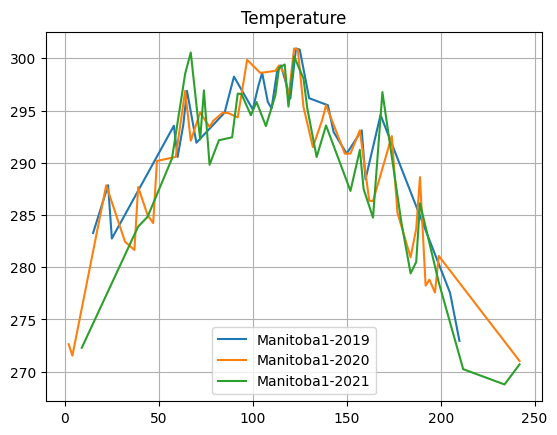

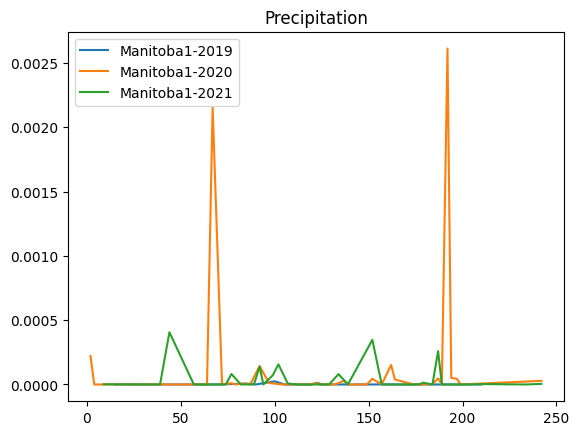

In [11]:
def images_time_info(
    img_keys: List[str]
) -> Tuple [List, List, List]:
    """
    Changes the images dates to the natural number day after query begins.
    Returns list of natural number days, list of dates, list of hours.
    """
    # Lists of dates, hours and timestamps.
    dates_list = []
    hours_list = []
    timestamps_list = []
    # Iterate over the key list.
    for image_details in img_keys:
        # Parse the date from the key.
        date = pd.to_datetime(image_details[0:15])
        day_format = date.strftime('%Y-%m-%d')
        dates_list.append(day_format)
        timestamps_list.append(date)
        # Hours from images retrieved
        hour_of_day = date.strftime('%H:%M')
        hours_list.append(hour_of_day)

    # Sorts.
    dates_list.sort()
    timestamps_list.sort()

    year = timestamps_list[0].year
    # List of numbers.
    initial_date = datetime.strptime(str(year) +"-04-01", '%Y-%m-%d')
    # Calculate the differences between the initial and the nexts days.
    day_numbers = [datetime.strptime(day, '%Y-%m-%d') - initial_date for day in dates_list]
    # Get the difference in days.
    day_numbers = [day // timedelta(days=1) for day in day_numbers]

    return day_numbers, timestamps_list, hours_list

# Temperature and precipitation arrays
location="Manitoba1"
all_temp=[]
all_preci=[]
for year in ["2019","2020","2021"]:
    IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\\'+location+'-'+year)
    band_labels = ["B4", "B3", "B2", "B8"]
    images = utils.load_landsat_image(IMGS_PATH, band_labels)
    img_keys = list(images.keys())
    days, timestamps_list, hours_list = images_time_info(img_keys)

    # Creates dictionary with all data
    temp_preci_dict = utils.data_extrator_temp(data_tp,int(year))
    # Retrieves specific values according to images
    temp,preci = utils.get_temp_and_preci(temp_preci_dict, timestamps_list)
    all_temp.extend(temp)
    all_preci.extend(preci)
    
    plt.figure(1)
    plt.title("Temperature")
    plt.plot(days,temp,label=location+'-'+year)
    plt.grid()
    plt.legend()

    plt.figure(2)
    plt.title("Precipitation")
    plt.plot(days,preci,label=location+'-'+year)
    plt.legend()
    
    print("This year data begins "+ str(days[0]) + " days after 04/01/"+year)

## Data obtained with time version 2 (days after query begins)

Passed to next year
This year data begins 15 days after 04/01/2019
Passed to next year
This year data begins 368 days after 04/01/2019
Passed to next year
This year data begins 740 days after 04/01/2019


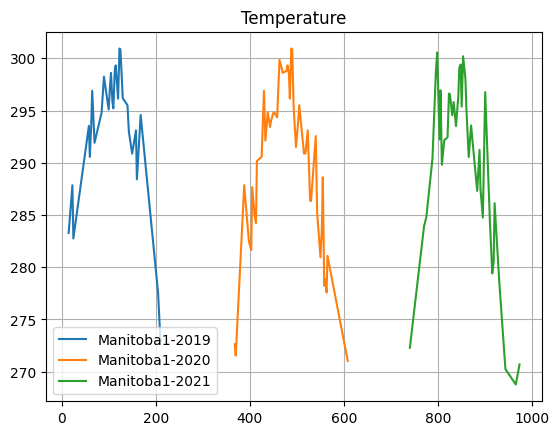

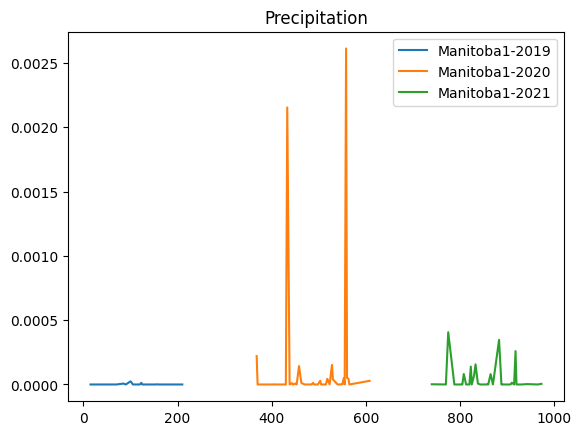

In [12]:
from typing import List, Tuple
import pandas as pd
def images_time_info(
    img_keys: List[str]
) -> Tuple [List, List, List]:
    """
    Changes the images dates to the natural number day after query begins.
    Returns list of natural number days, list of dates, list of hours.
    """
    # Lists of dates, hours and timestamps.
    dates_list = []
    hours_list = []
    timestamps_list = []
    # Iterate over the key list.
    for image_details in img_keys:
        # Parse the date from the key.
        date = pd.to_datetime(image_details[0:15])
        day_format = date.strftime('%Y-%m-%d')
        dates_list.append(day_format)
        timestamps_list.append(date)
        # Hours from images retrieved
        hour_of_day = date.strftime('%H:%M')
        hours_list.append(hour_of_day)

    # Sorts.
    dates_list.sort()
    timestamps_list.sort()

    year = timestamps_list[0].year
    # List of numbers.
    initial_date = datetime.strptime("2019-04-01", '%Y-%m-%d')
    # Calculate the differences between the initial and the nexts days.
    day_numbers = [datetime.strptime(day, '%Y-%m-%d') - initial_date for day in dates_list]
    # Get the difference in days.
    day_numbers = [day // timedelta(days=1) for day in day_numbers]

    return day_numbers, timestamps_list, hours_list

# Temperature and precipitation arrays
location="Manitoba1"
all_temp=[]
all_preci=[]

# Iterate for every year.
for year in ["2019","2020","2021"]:
    IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\\'+location+'-'+year)
    band_labels = ["B4", "B3", "B2", "B8"]
    images = utils.load_landsat_image(IMGS_PATH, band_labels)
    img_keys = list(images.keys())
    days, timestamps_list, hours_list = images_time_info(img_keys)

    # Creates dictionary with all data
    temp_preci_dict = utils.data_extrator_temp(data_tp,int(year))
    # Retrieves specific values according to images
    temp,preci = utils.get_temp_and_preci(temp_preci_dict, timestamps_list)
    # Adds values of every year to an all values array
    all_temp.extend(temp)
    all_preci.extend(preci)
    
    plt.figure(1)
    plt.title("Temperature")
    plt.plot(days,temp,label=location+'-'+year)
    plt.grid()
    plt.legend()

    plt.figure(2)
    plt.title("Precipitation")
    plt.plot(days,preci,label=location+'-'+year)
    plt.legend()
    print("Passed to next year")
    print("This year data begins "+ str(days[0]) + " days after 04/01/2019") 

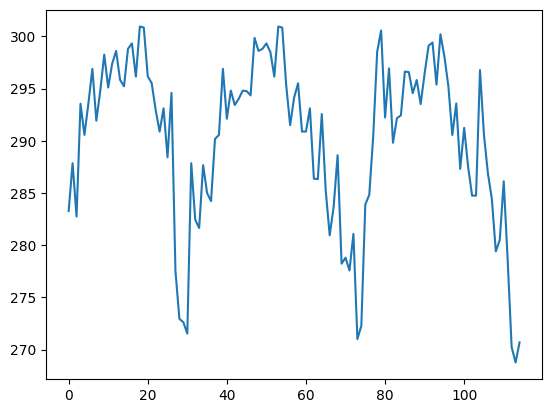

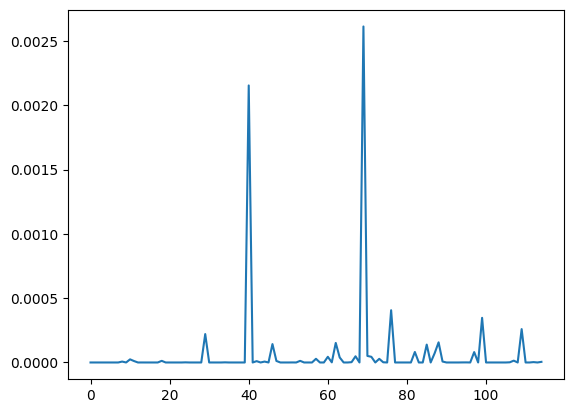

In [10]:
len(all_preci), len(all_preci)

plt.plot(all_temp)

plt.figure()
plt.plot(all_preci)